In [1]:
# Insert code here.
import pandas as pd
import numpy as np
import random
import re
import time
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, BertConfig
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
# from sentence_transformers import SentenceTransformer
# sent_encoder = SentenceTransformer('bert-base-nli-mean-tokens')

In [2]:
models = ['bert-base-multilingual-cased', 'xlm-roberta-base', 'sagorsarker/bangla-bert-base']
model_num = 1
tokenizer = AutoTokenizer.from_pretrained(models[model_num])


In [3]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
torch.cuda.empty_cache()

There are 4 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [4]:
DATASET_PATH= '../datasets/banfake/LabeledAuthentic-7K.csv'

In [5]:
df = pd.read_csv(DATASET_PATH)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 7,202



,articleID,domain,date,category,source,relation,headline,content,label
3295,3498,risingbd.com,2018-09-22 18:28:16,National,পুলিশ,Related,পেট্রোল বোমাসহ ৫ শিবিরকর্মী গ্রেপ্তার,সিরাজগঞ্জ সংবাদদাতা : নাশকতার পরিকল্পনার অভিযো...,0.0
5650,6311,banglatribune.com,2018-09-19 19:16:05,Miscellaneous,"দুদকের জনসংযোগ কর্মকর্তা,দুদকের মহাপরিচালক (প্...",Related,হঠাৎ বিএসটিআই কার্যালয়ে দুদক,বিভিন্ন ভোজ্যতেলের মান সঠিকভাবে নিরীক্ষিত হচ্ছ...,1.0
4297,4651,jugantor.com,2018-09-22 11:54:10,Editorial,reporter,Related,২২ সেপ্টেম্বর: ইতিহাসে আজকের এই দিনে,"আজ ২২ সেপ্টেম্বর ২০১৮, শনিবার। ০৭ আশ্বিন, ১৪২৪...",0.0
6807,7757,jagonews24.com,2018-09-23 00:24:29,National,শরীয়তপুর পৌরসভার ৮নং ওয়ার্ডের কাউন্সিলর,Related,দক্ষিণ আফ্রিকায় ঘোড়ার কবলে পড়ে বাংলাদেশি যুবক ...,দক্ষিণ আফ্রিকায় ঘোড়ার কবলে পড়ে ফারুক হাওলাদার ...,1.0
6310,7139,jagonews24.com,2018-09-25 21:47:24,Crime,Reporter,Related,যমুনা টিভি ও যুগান্তরের বিরুদ্ধে প্রাণ-আরএফএল ...,মিথ্যা ও মানহানিকর সংবাদ প্রকাশের অভিযোগে যমুন...,1.0
4166,4499,somoynews.tv,2018-09-19 18:18:32,Sports,Reporter,Related,উইকেটের জন্য মরিয়া ভারত,বাচা-মরার লড়াইয়ে ভারতের বিপক্ষে কঠিন লড়াই করছে...,0.0
469,475,dailynayadiganta.com,2018-09-22 13:02:43,Politics,আওয়ামী লীগের সাধারণ সম্পাদক এবং সড়ক পরিবহন ও স...,Related,ঐক্যবদ্ধ থাকলে আগামী নির্বাচনেও বিজয়ী হবো : ওব...,আওয়ামী লীগের সাধারণ সম্পাদক এবং সড়ক পরিবহন ও স...,0.0
698,709,risingbd.com,2018-09-22 17:16:49,Miscellaneous,reporter,Related,মেয়েরা ঠিক যেখানে টিপ পরে,(ভিয়েতনামের পথে: ৪২তম পর্ব) ফেরদৌস জামান: দুই ...,0.0
2902,3073,banglatribune.com,2018-09-20 01:14:07,National,Reporter,Related,বরিশালে স্ত্রী হত্যায় একজনের যাবজ্জীবন,বরিশালে স্ত্রী হত্যার দায়ে মনোয়ার হোসেন হাওলাদ...,1.0
610,618,jagonews24.com,2018-09-21 16:36:31,Entertainment,Reporter,Related,কারিনার এই শার্টের দাম কত জানেন?,৩৮-এ বয়সে পা রাখলেন কারিনা কাপুর খান। গতকাল বৃ...,0.0


In [6]:
def count_words(text):
    try:
        return len(text.split())
    except:
        print(text)
        return None
def change_rel(num):
    return int(num)

In [7]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = []

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#     text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['content'] = df['content'].apply(clean_text)
df['content'] = df['content'].str.replace('\d+', '')
df['label'] = df['label'].apply(change_rel)

In [8]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//120 >0:
        n = len(text1.split())//120
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:160]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*120:w*120 + 160]
            l_total.append(" ".join(l_parcial))
    return l_total
df['content_split'] = df['content'].apply(get_split)

In [9]:
df['content'].apply(count_words).mean()

253.42793668425438

In [10]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['content_split'], df['label'], test_size=0.2, stratify=df['label'])

In [11]:
train_l = []
label_l = []
index_l =[]
for row,label in zip(train_x, train_y):
    for l in row:
        train_l.append(l)
        label_l.append(label)
len(train_l), len(label_l)

(10406, 10406)

In [12]:
val_l = []
val_label_l = []
val_index_l = []
for row,label in zip(valid_x, valid_y):
    for l in row:
        val_l.append(l)
        val_label_l.append(label)
len(val_l), len(val_label_l)

(2621, 2621)

In [13]:
MAX_LENGTH = 220
posts = train_l
categories = label_l

In [14]:
encoded_dict = tokenizer.encode_plus(
                        posts[0],                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
posts[0], encoded_dict

/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


('গেল তিন বছরে ধারাবাহিক টাইগাররা টুর্নামেন্ট জেতার এটা উপযুক্ত সময় মাশরাফী-সাকিবদের বলেছেন সাবেক ভারতীয় পেইসার অজিত আগারকার। তার মতে সামর্থ্য বিবেচনায় বাংলাদেশের বড় কোন ট্রফি জয়ের প্রত্যাশা মোটেও বাড়াবাড়ি নয়। শাহরিয়ার নাফিস আশা দেখছেন বলেছেন খুব কময়ের মধ্যেই টুর্নামেন্ট জিতবে টাইগাররা। বাংলাদেশকে এখন খাটো করে দেখে না ভারত। সবশেষ ওডিআই সিরিজ হারের ক্ষত এখনো পোড়ায়। ওয়ার্ল্ড টি টোয়েন্টি কিংবা নিদাহাস ট্রফিতে টাইগার থাবা থেকে কোনমতে বেঁচেছে টিম ইন্ডিয়া। সাকিব-তামিমরাও খুব কাছে গিয়ে ট্রফি না জেতার আক্ষেপ বয়ে বেড়াচ্ছেন। ভারত-বাংলাদেশ ম্যাচ এখন দর্শক টানে। যারা একসময় নিন্দা করতেন তারাও টাইগারদের সমীহ করতে বাধ্য। সাবেকদের চোখে মাশরাফীর দলটা পরিণত। ধারাবাহিকতায় সময় এসেছে বড় কোন সাফল্যের। ভারতের সাবেক পেসার অজিত আগারকার বলেন ক্রিকেট ক্রেজি একটা নেশন বাংলাদেশকে নিয়ে প্রত্যাশা সবসময় বেশি। ওরা ধারাবাহিকভাবে ভালো করছে এখন একটা বড় টুর্নামেন্ট জিতবে সে আশা করাই যায়। ভালো খেলছে ঠিক আছে দারুন কিছু জয়ও পাচ্ছে কোয়ার্টার ফাইনাল কিংবা সেমিফাইনাল খেলছেন। তবে একটা সময় আসে যখন আপনাকে বড় টুর্নামেন্ট জিততে হবে।

In [15]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

In [16]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.875 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


9,105 training samples
1,301 validation samples


In [17]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [18]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    models[model_num], # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weig

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [19]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           

In [20]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [21]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [22]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [23]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [24]:
seed_val = 42
torch.cuda.empty_cache()
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    if epoch_i >= 1:
        inp = input()
        if inp.startswith('y'):
            break

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    570.    Elapsed: 0:00:10.
  Batch    80  of    570.    Elapsed: 0:00:21.
  Batch   120  of    570.    Elapsed: 0:00:31.
  Batch   160  of    570.    Elapsed: 0:00:41.
  Batch   200  of    570.    Elapsed: 0:00:52.
  Batch   240  of    570.    Elapsed: 0:01:02.
  Batch   280  of    570.    Elapsed: 0:01:13.
  Batch   320  of    570.    Elapsed: 0:01:23.
  Batch   360  of    570.    Elapsed: 0:01:34.
  Batch   400  of    570.    Elapsed: 0:01:44.
  Batch   440  of    570.    Elapsed: 0:01:55.
  Batch   480  of    570.    Elapsed: 0:02:06.
  Batch   520  of    570.    Elapsed: 0:02:16.
  Batch   560  of    570.    Elapsed: 0:02:27.

  Average training loss: 0.70
  Training epcoh took: 0:02:29

Running Validation...
  Accuracy: 0.44
  Validation Loss: 0.69
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    570.    Elapsed: 0:00:11.
  Batch    80  of    570.    Elapsed: 0:00:21.
  Batch  

 y



Training complete!
Total training took 0:05:29 (h:mm:ss)


In [25]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.""
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.70,0.69,0.44,0:02:29,0:00:06
2,0.69,0.69,0.56,0:02:31,0:00:06


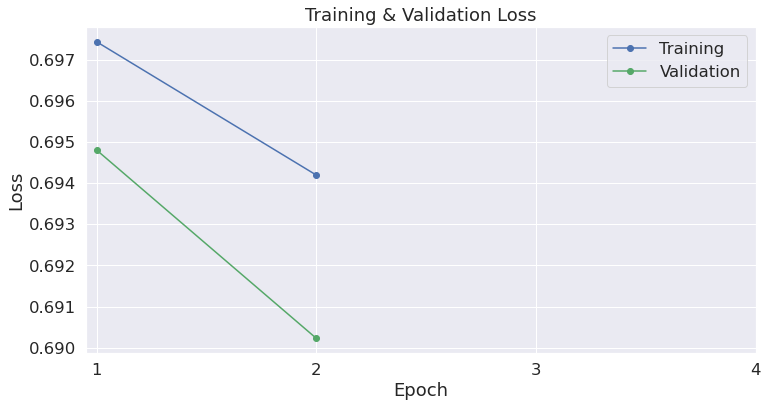

In [26]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [27]:
posts = valid_x.values
categories = valid_y.values

In [28]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 1,441 test sentences...
    DONE.


In [30]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
predicts = []
accurate = 0
total_len = 0
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    predicts.append(pred_labels_i)
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)

    matthews_set.append(matthews)
    for j in range(len(true_labels[i])):
        if true_labels[i][j] == pred_labels_i[j]:
            accurate+=1
        total_len+=1
print("Accuracy:",accurate/total_len)

Calculating Matthews Corr. Coef. for each batch...
Accuracy: 0.5503122831367107


/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [31]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       648
           1       0.55      1.00      0.71       793

    accuracy                           0.55      1441
   macro avg       0.28      0.50      0.35      1441
weighted avg       0.30      0.55      0.39      1441



/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
